In [53]:
train = pd.read_csv("data/train.csv")
original_train = train.copy()
test = pd.read_csv("data/test.csv")
original_test = test.copy()

### train

In [56]:
# 반품 발생은 0으로 표기하는 컬럼 추가
train["Count"] = train["ScanCount"]
train.loc[train.Count < 0, "Count"] = 0
# Fineline 없는 것은 9999로 명시
train["FinelineNumber"].fillna(value=9999, inplace=True)
# Upc 없는 것은 -1로 명시
train["Upc"].fillna(value=-1, inplace=True)

In [57]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])

In [58]:

# VisitNumber, DepartmentDescription으로 groupby. ScanCount sum(총 판매량) 
df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

train = train.merge(df1, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df2, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df3, how='left', on=["VisitNumber"], copy=True)  

train["Range"] = train["Max"] - train["Min"]

In [59]:
df = train[train["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True) 
train["Null_Depts"].fillna(value=1, inplace=True)
train.loc[train.Null_Depts > 0, "Null_Depts"] = 0

In [61]:
df = train[train["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "ReturnCount"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["ReturnCount"].fillna(value=1, inplace=True)
train.loc[train.ReturnCount > 0, "ReturnCount"] = 0

In [62]:
# Indicator for missing FinelineNumber

df = train[train["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["Null_Fineline"].fillna(value=1, inplace=True)
train.loc[train.Null_Fineline > 0, "Null_Fineline"] = 0

In [71]:
# 각 VisitNumber 당 총 구매한 FinelineNumber의 수

df = train.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [64]:
# 각 소비자 당 총 구매한 UPC의 수

df = train.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [66]:
# 각 소비자 당 총 구매한 DepartmentDescription의 수

df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Depts"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [67]:
df = train.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Sum"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [72]:
train["Ratio_F_D"] = train["N_Fineline"] / train["N_Depts"]
train["Ratio_U_D"] = train["N_Upc"] / train["N_Depts"]
train.shape

(647054, 21)

In [73]:
train["mean_to_min"] = train["Mean"] / train["Min"]
train.loc[train.mean_to_min==0, "mean_to_min"] = 1
train['max_to_mean'] = train["Max"] / train["Mean"]
train.loc[train.max_to_mean==0, "max_to_mean"] = 1

In [74]:
train.drop("Upc", axis=1, inplace=True)
train.shape

(647054, 22)

In [78]:
# 최빈값 함수
from collections import Counter
def mode(x):
    counts = Counter(x)
    max_count = max(counts.values())
    ls = [x_i for x_i, count in counts.items() if count == max_count]
    return ls[0]

In [79]:
to_grouped = train[["VisitNumber", "FinelineNumber"]]
mf_fineline = to_grouped.groupby("VisitNumber", as_index=False).agg(mode)

In [80]:
depts_dummies = pd.get_dummies(train.DepartmentDescription)
depts_dummies.drop("HEALTH AND BEAUTY AIDS", axis=1, inplace=True)

In [81]:
depts_dummies = pd.concat([train[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_grouped = depts_dummies.groupby("VisitNumber", as_index=False).sum()
depts_dummies_grouped.shape

(95674, 68)

In [82]:
def make_fineline_dummies(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
    fineline_ranks = data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_train[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [83]:
fineline_dummies_grouped = make_fineline_dummies(train)

In [84]:
train = train.replace(np.inf, 0)
train = train.fillna(value=0)

In [86]:
train.drop(["DepartmentDescription"], axis=1, inplace=True)

In [87]:
train_by_max = train.groupby("VisitNumber", as_index=False).agg(np.max) # ScanCount --> Sum

In [88]:
train_grouped = train_by_max.merge(depts_dummies_grouped, how='left', on=["VisitNumber"])
train_grouped = train_grouped.merge(fineline_dummies_grouped, how='left', on=["VisitNumber"])
train_grouped.shape

(95674, 362)

In [90]:
def grouping_depts(data):
    data["OPTICAL"] = data["OPTICAL - LENSES"] + data["OPTICAL - FRAMES"]
    data["DELI"] = data["SERVICE DELI"] + data["PRE PACKED DELI"]

    data["WOMENS CLOTHES"] = data["PLUS AND MATERNITY"] + data["LADIES SOCKS"] +\
                             data["LADIES SOCKS"] + data["BRAS & SHAPEWEAR"]
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["PLAYERS AND ELECTRONICS"]
    data["LADIESWEAR"] = data["LADIESWEAR"] + data["WOMENS CLOTHES"]

    data["PHARMACY"] = data["PHARMACY RX"] + data["PHARMACY OTC"]
    data["LAWN AND GARDEN"] = data["LAWN AND GARDEN"] + data["HORTICULTURE AND ACCESS"]
    data["LADIESWEAR"] = data["SHEER HOSIERY"] + data["LADIESWEAR"]

    data["CLOTHES"] = data["BOYS WEAR"] + data["MENSWEAR"] + data["SWIMWEAR/OUTERWEAR"] +\
                      data['GIRLS WEAR, 4-6X  AND 7-14'] + data["INFANT APPAREL"] +\
                      data["LADIESWEAR"] + data["MENS WEAR"] + data["SLEEPWEAR/FOUNDATIONS"]

    data["GROCERIES"] = data["BAKERY"] + data["COMM BREAD"] + data["DAIRY"] + data["DSD GROCERY"] +\
                        data["FROZEN FOODS"] + data["GROCERY DRY GOODS"] + data["MEAT - FRESH & FROZEN"] +\
                        data["PRODUCE"] + data["SEAFOOD"] + data["DELI"]

    data["CLOTHES"] = data["CLOTHES"] + data["SHOES"]
    data["HOME"] = data["BATH AND SHOWER"] + data["HOME DECOR"] + data["HOME MANAGEMENT"] +\
                   data["BEDDING"] + data["COOK AND DINE"] + data["FURNITURE"] +\
                   data["LARGE HOUSEHOLD GOODS"] + data["SEASONAL"]

    data["JEWELRY AND ACCESSORIES"] = data["JEWELRY AND SUNGLASSES"] + data["ACCESSORIES"]
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["CAMERAS AND SUPPLIES"]

    data['HOUSEHOLD GOODS'] = data['HOUSEHOLD PAPER GOODS'] + data['HOUSEHOLD CHEMICALS/SUPP']
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["WIRELESS"]
    data["BEAUTY AND PERSONAL CARE"] = data["BEAUTY"] + data["PERSONAL CARE"]

#     to_drop = ["OPTICAL - FRAMES", "OPTICAL - LENSES", "CONCEPT STORES",
#                "OTHER DEPARTMENTS", "PRE PACKED DELI", "SERVICE DELI", "PLUS AND MATERNITY", "LADIES SOCKS",
#                "BRAS & SHAPEWEAR", "PLAYERS AND ELECTRONICS", "WOMENS CLOTHES", "PHARMACY RX", "PHARMACY OTC",
#                "HORTICULTURE AND ACCESS", "SHEER HOSIERY", "BOYS WEAR", "MENSWEAR", "SWIMWEAR/OUTERWEAR",
#                "GIRLS WEAR, 4-6X  AND 7-14", "INFANT APPAREL", "LADIESWEAR", "MENS WEAR", "SLEEPWEAR/FOUNDATIONS",
#                "BAKERY", "COMM BREAD", "DAIRY", "DSD GROCERY", "FROZEN FOODS", "GROCERY DRY GOODS",
#                "MEAT - FRESH & FROZEN","PRODUCE", "SEAFOOD", "DELI", "SHOES", "HOME DECOR", "BATH AND SHOWER",
#                "HOME MANAGEMENT", "BEDDING","COOK AND DINE", "FURNITURE", "LARGE HOUSEHOLD GOODS",
#                "SEASONAL", "JEWELRY AND SUNGLASSES", "ACCESSORIES", "CAMERAS AND SUPPLIES",
#                "HOUSEHOLD CHEMICALS/SUPP", "HOUSEHOLD PAPER GOODS", "WIRELESS", "BEAUTY", "PERSONAL CARE"]
    
    return data

In [96]:
train_depts_group = grouping_depts(train_grouped)

In [99]:
#train_depts_group.drop(9999, axis=1, inplace=True)
train_depts_group = pd.concat([train_depts_group, mf_fineline[["FinelineNumber"]]], axis=1)
train_depts_group = pd.get_dummies(train_depts_group, columns=["Weekday"])

In [100]:
train_depts_group.head()

,VisitNumber,TripType,ScanCount,FinelineNumber,Count,Min,Max,Mean,Range,Null_Depts,...,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,5,999,-1,1000.0,0,0.0,0.0,0.000000,0.0,0.0,...,0,0,1000.0,0,0,0,0,1,0,0
1,7,30,1,8931.0,1,1.0,1.0,1.000000,0.0,0.0,...,0,1,8931.0,0,0,0,0,1,0,0
2,8,26,3,9999.0,3,1.0,20.0,4.833333,19.0,0.0,...,1,0,3565.0,0,0,0,0,1,0,0
3,9,8,1,5501.0,1,1.0,2.0,1.500000,1.0,0.0,...,0,0,115.0,0,0,0,0,1,0,0
4,10,8,1,7950.0,1,1.0,2.0,1.500000,1.0,0.0,...,0,0,2008.0,0,0,0,0,1,0,0


In [120]:
train_depts_group.drop(train_depts_group.iloc[:, 172:359], axis=1, inplace=True)

In [122]:
train_depts_group = train_depts_group.set_index('VisitNumber')

In [203]:
train_depts_group.head()

,TripType,ScanCount,FinelineNumber,Count,Min,Max,Mean,Range,Null_Depts,ReturnCount,...,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,37,-1,1000.0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,1000.0,0,0,0,0,1,0,0
7,22,1,8931.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,...,0,1,8931.0,0,0,0,0,1,0,0
8,18,3,9999.0,3,1.0,20.0,4.833333,19.0,0.0,0.0,...,1,0,3565.0,0,0,0,0,1,0,0
9,5,1,5501.0,1,1.0,2.0,1.500000,1.0,0.0,0.0,...,0,0,115.0,0,0,0,0,1,0,0
10,5,1,7950.0,1,1.0,2.0,1.500000,1.0,0.0,0.0,...,0,0,2008.0,0,0,0,0,1,0,0


In [164]:
train_depts_group.drop([7557.0], axis=1, inplace=True)

In [166]:
train_depts_group.to_csv("data/0408_train.csv")

### test

In [129]:
# 반품 발생은 0으로 표기하는 컬럼 추가
test["Count"] = test["ScanCount"]
test.loc[test.Count < 0, "Count"] = 0
# Fineline 없는 것은 9999로 명시
test["FinelineNumber"].fillna(value=9999, inplace=True)
# Upc 없는 것은 -1로 명시
test["Upc"].fillna(value=-1, inplace=True)

In [130]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

In [131]:
# VisitNumber, DepartmentDescription으로 groupby. ScanCount sum(총 판매량) 
df = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

test = test.merge(df1, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df2, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df3, how='left', on=["VisitNumber"], copy=True)  

test["Range"] = test["Max"] - test["Min"]

In [132]:
df = test[test["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 
test["Null_Depts"].fillna(value=1, inplace=True)
test.loc[test.Null_Depts > 0, "Null_Depts"] = 0

In [133]:
df = test[test["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "ReturnCount"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)
test["ReturnCount"].fillna(value=1, inplace=True)
test.loc[test.ReturnCount > 0, "ReturnCount"] = 0

In [134]:
# Indicator for missing FinelineNumber

df = test[test["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)
test["Null_Fineline"].fillna(value=1, inplace=True)
test.loc[test.Null_Fineline > 0, "Null_Fineline"] = 0

In [135]:
# 각 VisitNumber 당 총 구매한 FinelineNumber의 수

df = test.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [136]:
# 각 소비자 당 총 구매한 UPC의 수

df = test.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [137]:
# 각 소비자 당 총 구매한 DepartmentDescription의 수

df = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Depts"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [138]:
df = test.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Sum"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [139]:
test["Ratio_F_D"] = test["N_Fineline"] / test["N_Depts"]
test["Ratio_U_D"] = test["N_Upc"] / test["N_Depts"]
test.shape

(653646, 20)

In [140]:
test["mean_to_min"] = test["Mean"] / test["Min"]
test.loc[test.mean_to_min==0, "mean_to_min"] = 1
test['max_to_mean'] = test["Max"] / test["Mean"]
test.loc[test.max_to_mean==0, "max_to_mean"] = 1

In [141]:
test.drop("Upc", axis=1, inplace=True)
test.shape

(653646, 21)

In [142]:
to_grouped = test[["VisitNumber", "FinelineNumber"]]
mf_fineline = to_grouped.groupby("VisitNumber", as_index=False).agg(mode)

In [149]:
depts_dummies = pd.get_dummies(test.DepartmentDescription)
#depts_dummies.drop("HEALTH AND BEAUTY AIDS", axis=1, inplace=True)

In [150]:
depts_dummies = pd.concat([test[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_grouped = depts_dummies.groupby("VisitNumber", as_index=False).sum()
depts_dummies_grouped.shape

(95674, 68)

In [151]:
def make_fineline_dummies(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
    fineline_ranks = data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_test[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [152]:
fineline_dummies_grouped = make_fineline_dummies(test)

In [153]:
test = test.replace(np.inf, 0)
test = test.fillna(value=0)

In [154]:
test.drop(["DepartmentDescription"], axis=1, inplace=True)

In [155]:
test_by_max = test.groupby("VisitNumber", as_index=False).agg(np.max) # ScanCount --> Sum

In [156]:
test_grouped = test_by_max.merge(depts_dummies_grouped, how='left', on=["VisitNumber"])
test_grouped = test_grouped.merge(fineline_dummies_grouped, how='left', on=["VisitNumber"])
test_grouped.shape

(95674, 368)

In [157]:
test_depts_group = grouping_depts(test_grouped)

In [158]:
test_depts_group.drop(9999, axis=1, inplace=True)
test_depts_group = pd.concat([test_depts_group, mf_fineline[["FinelineNumber"]]], axis=1)
test_depts_group = pd.get_dummies(test_depts_group, columns=["Weekday"])

In [173]:
to_drop = [ 1000.0, 1006.0, 1008.0, 1014.0, 1025.0, 1026.0, 103.0, 104.0,
 105.0, 1077.0, 109.0,1101.0,1104.0,1202.0,125.0, 130.0,1301.0,
 1311.0, 1344.0, 1351.0, 1352.0, 1353.0, 1356.0, 140.0, 1402.0,
 1403.0, 1405.0, 1406.0, 1411.0, 1513.0, 1801.0, 1855.0, 19.0,
 1903.0, 1946.0, 1951.0, 1952.0, 2003.0, 2005.0, 2006.0, 2008.0,
 2041.0, 205.0, 2070.0, 2105.0, 211.0, 221.0, 2286.0, 2301.0, 2302.0,
 2303.0, 2352.0, 2400.0, 2403.0, 2452.0, 250.0, 2602.0, 2651.0,
 2707.0, 2708.0, 275.0, 2758.0, 276.0, 2764.0, 277.0, 278.0,
 279.0, 2804.0, 2901.0, 2992.0, 2997.0, 2998.0, 3000.0, 3002.0,
 3005.0, 3010.0, 302.0, 3050.0, 3054.0, 3070.0, 31.0, 3100.0,
 3105.0, 3108.0, 3163.0, 3181.0, 3183.0, 324.0, 3300.0, 3301.0,
 3304.0, 3306.0, 3352.0, 338.0, 3504.0, 3554.0, 3559.0, 3605.0, 3630.0,
 3704.0, 3706.0, 3707.0, 3710.0, 3712.0, 3719.0, 3725.0, 3804.0,
 3815.0, 3901.0, 3903.0, 4001.0, 4005.0, 4008.0, 401.0, 402.0, 403.0,
 4102.0, 4138.0, 4201.0, 4253.0, 4292.0, 4293.0, 4351.0, 4408.0,
 4501.0,
 4503.0,
 4510.0,
 4623.0,
 4628.0,
 4635.0,
 4639.0,
 4654.0,
 5010.0,
 5020.0,
 5024.0,
 5030.0,
 5050.0,
 521.0,
 53.0,
 5510.0,
 5550.0,
 5701.0,
 585.0,
 6.0,
 60.0,
 6010.0,
 6020.0,
 6030.0,
 6080.0,
 610.0,
 6106.0,
 6124.0,
 6158.0,
 6201.0,
 6300.0,
 6501.0,
 7002.0,
 701.0,
 702.0,
 705.0,
 7100.0,
 7502.0,
 7801.0,
 787.0,
 79.0,
 7953.0,
 7957.0,
 7960.0,
 8012.0,
 8015.0,
 8023.0,
 805.0,
 807.0,
 8103.0,
 8104.0,
 8251.0,
 8303.0,
 8400.0,
 8945.0,
 901.0,
 9020.0,
 9108.0,
 9114.0,
 9115.0,
 9206.0,
 9211.0,
 9214.0,
 9216.0,
 9251.0,
 9515.0,
 9516.0,
 9538.0,
 9547.0,
 9550.0,
 9704.0]

In [176]:
test_depts_group.drop(to_drop, axis=1, inplace=True)

In [179]:
test_depts_group = test_depts_group.set_index('VisitNumber')

In [180]:
test_depts_group.head()

,ScanCount,FinelineNumber,Count,Min,Max,Mean,Range,Null_Depts,ReturnCount,Null_Fineline,...,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
VisitNumber,,,,,,,,,,,,,,,,,,,,,
1,1,3555.0,1,1.0,2.0,1.333333,1.0,0.0,0.0,0.0,...,0,0,3002.0,0,0,0,0,1,0,0
2,1,8023.0,1,1.0,2.0,1.333333,1.0,0.0,0.0,0.0,...,0,0,8023.0,0,0,0,0,1,0,0
3,1,4504.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,...,0,2,4504.0,0,0,0,0,1,0,0
4,1,5924.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,...,0,0,5924.0,0,0,0,0,1,0,0
6,1,654.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,...,0,0,654.0,0,0,0,0,1,0,0


In [183]:
test_depts_group.to_csv("data/0408_test.csv")

In [182]:
a = train_depts_group.columns.unique()
b = test_depts_group.columns.unique()
set(b) - set(a)

set()

In [184]:
train = train_depts_group
test = test_depts_group

In [187]:
train['TripType'] = train['TripType'].map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 12:7, 14:8, 15:9,  
                                         18:10, 19:11, 20:12, 21:13, 22:14, 23:15, 24:16, 25:17, 26:18,  
                                         27:19, 28:20, 29:21, 30:22, 31:23, 32:24, 33:25, 34:26, 35:27, 
                                         36:28, 37:29, 38:30, 39:31, 40:32, 41:33, 42:34, 43:35, 44:36, 999:37})

In [188]:
train.head()

,TripType,ScanCount,FinelineNumber,Count,Min,Max,Mean,Range,Null_Depts,ReturnCount,...,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,37,-1,1000.0,0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,1000.0,0,0,0,0,1,0,0
7,22,1,8931.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,...,0,1,8931.0,0,0,0,0,1,0,0
8,18,3,9999.0,3,1.0,20.0,4.833333,19.0,0.0,0.0,...,1,0,3565.0,0,0,0,0,1,0,0
9,5,1,5501.0,1,1.0,2.0,1.500000,1.0,0.0,0.0,...,0,0,115.0,0,0,0,0,1,0,0
10,5,1,7950.0,1,1.0,2.0,1.500000,1.0,0.0,0.0,...,0,0,2008.0,0,0,0,0,1,0,0


In [200]:
test_VN = test.reset_index()
test_VN.head()

,VisitNumber,ScanCount,FinelineNumber,Count,Min,Max,Mean,Range,Null_Depts,ReturnCount,...,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,1,3555.0,1,1.0,2.0,1.333333,1.0,0.0,0.0,...,0,0,3002.0,0,0,0,0,1,0,0
1,2,1,8023.0,1,1.0,2.0,1.333333,1.0,0.0,0.0,...,0,0,8023.0,0,0,0,0,1,0,0
2,3,1,4504.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,...,0,2,4504.0,0,0,0,0,1,0,0
3,4,1,5924.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,...,0,0,5924.0,0,0,0,0,1,0,0
4,6,1,654.0,1,1.0,1.0,1.000000,0.0,0.0,0.0,...,0,0,654.0,0,0,0,0,1,0,0


In [4]:
test.head()

,ScanCount,Count,Min,Max,Mean,Range,Null_Depts,ReturnCount,Null_Fineline,N_Fineline,...,Prob_TOYS,Prob_WIRELESS,FinelineNumber,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
VisitNumber,,,,,,,,,,,,,,,,,,,,,
1,1,1,1.0,2.0,1.333333,1.0,0.0,0.0,0.0,4,...,0.013889,0.013889,3002.0,0,0,0,0,1,0,0
2,1,1,1.0,2.0,1.333333,1.0,0.0,0.0,0.0,3,...,0.013889,0.013889,8023.0,0,0,0,0,1,0,0
3,1,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1,...,0.014493,0.014493,4504.0,0,0,0,0,1,0,0
4,1,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1,...,0.014493,0.014493,5924.0,0,0,0,0,1,0,0
6,1,1,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1,...,0.014493,0.014493,654.0,0,0,0,0,1,0,0


In [189]:
len(train), len(test)

(95674, 95674)

### XGBoost

In [190]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

In [191]:
mytrain, mytest = train_test_split(train, test_size = .4)

In [192]:
mytrain_ = mytrain.drop(['TripType'], axis=1)
mytest_ = mytest.drop(['TripType'], axis=1)

In [193]:
dtrain = xgb.DMatrix(np.asarray(mytrain_), label = np.asarray(mytrain.TripType))
dtest = xgb.DMatrix(np.asarray(mytest_), label = np.asarray(mytest.TripType))

In [194]:
num_round = 300
param1 = {'objective': 'multi:softprob', 'num_class':38, "max_delta_step": 3}
watchlist1 = [(dtrain,'train'), (dtest, 'eval')]

bst = xgb.train(param1, dtrain, num_round, watchlist1, early_stopping_rounds=10)

[0]	train-merror:0.44321	eval-merror:0.453906
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[1]	train-merror:0.318218	eval-merror:0.338019
[2]	train-merror:0.302575	eval-merror:0.325817
[3]	train-merror:0.289649	eval-merror:0.315913
[4]	train-merror:0.283604	eval-merror:0.31236
[5]	train-merror:0.276322	eval-merror:0.309093
[6]	train-merror:0.270852	eval-merror:0.305513
[7]	train-merror:0.266236	eval-merror:0.303737
[8]	train-merror:0.260435	eval-merror:0.301516
[9]	train-merror:0.256898	eval-merror:0.300235
[10]	train-merror:0.250488	eval-merror:0.296864
[11]	train-merror:0.244373	eval-merror:0.293807
[12]	train-merror:0.239948	eval-merror:0.292866
[13]	train-merror:0.235663	eval-merror:0.290881
[14]	train-merror:0.230228	eval-merror:0.288686
[15]	train-merror:0.226517	eval-merror:0.286804
[16]	train-merror:0.223277	eval-merror:0.286177
[17]	train-merror:0.218905	eval-merror:0.284061
[

Accuracy score : 73.53%

In [197]:
dmtest = xgb.DMatrix(np.asarray(test)) 
pred_prob2 = bst.predict(dmtest)

In [198]:
col_array = np.asarray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [199]:
columns = {0:"TripType_3", 1: "TripType_4", 2: "TripType_5", 3: "TripType_6", 
                4: "TripType_7", 5: "TripType_8", 6: "TripType_9", 7: "TripType_12", 8: "TripType_14", 
                9: "TripType_15", 10: "TripType_18", 11: "TripType_19", 12: "TripType_20", 13: "TripType_21",
                14: "TripType_22", 15: "TripType_23", 16: "TripType_24", 17: "TripType_25", 18: "TripType_26", 
                19: "TripType_27", 20: "TripType_28", 21: "TripType_29", 22: "TripType_30", 23: "TripType_31", 
                24: "TripType_32", 25: "TripType_33", 26: "TripType_34", 27: "TripType_35", 28: "TripType_36", 
                29: "TripType_37", 30: "TripType_38", 31: "TripType_39", 32: "TripType_40", 33: "TripType_41", 
                34: "TripType_42", 35: "TripType_43", 36: "TripType_44", 37: "TripType_999"}

In [201]:
def predic_proba_to_csv(pred_prob):
    proba_df = pd.DataFrame(pred_prob, columns=col_array)
    proba_df.columns = proba_df.columns.map(lambda x: columns[x])
    sub_df = pd.concat([test_VN[["VisitNumber"]], proba_df], axis=1)
    return sub_df.to_csv("data/trial_16.csv", index=False)

In [202]:
predic_proba_to_csv(pred_prob2)

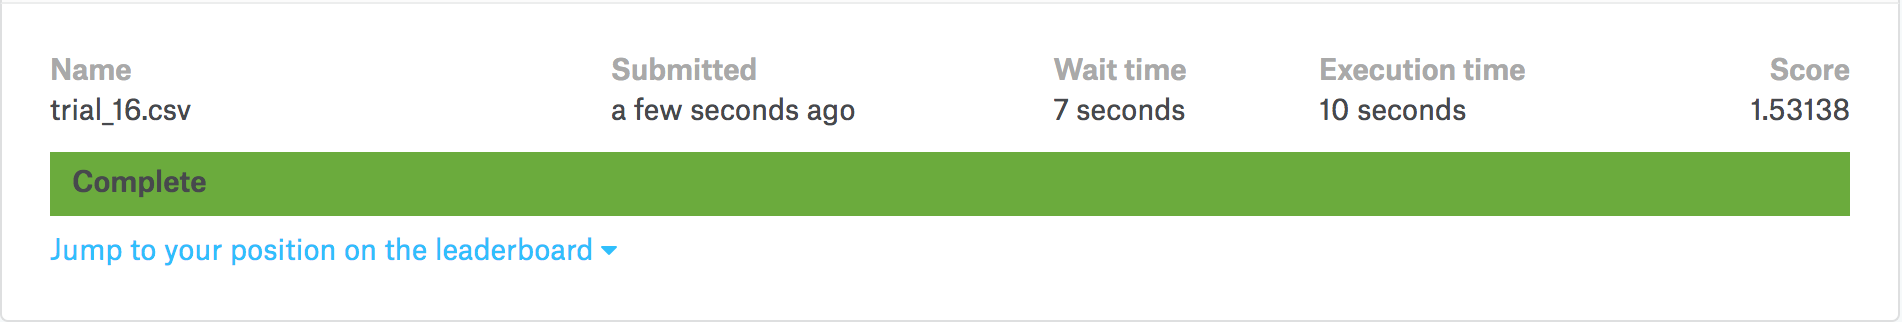